In [52]:
import torch 
from torchvision import transforms , models 
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

device = ("cuda" if torch.cuda.is_available() else "cpu")
from google.colab import drive
drive.mount('/content/drive')
! cp -r 'drive/MyDrive/ds301HW/neural style transfer' '/content' 

def model_activations(input,model): 
  global layers
  features = {}
  x = input
  x = x.unsqueeze(0)
  for name,layer in model._modules.items():
      x = layer(x)
      if name in layers:
          features[layers[name]] = x 
  return features

def imcnvt(image):
    x = image.to("cpu").clone().detach().numpy().squeeze()
    x = x.transpose(1,2,0)
    x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    return np.clip(x,0,1)

def gram_matrix(imgfeature):
    _,d,h,w = imgfeature.size()
    imgfeature = imgfeature.view(d,h*w)
    gram_mat = torch.mm(imgfeature,imgfeature.t())
    return gram_mat

def preprocess_and_plot(plot = True):
  global content_path, style_path
  transform = transforms.Compose([transforms.Resize(300),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

  content = Image.open(content_path).convert("RGB")
  content = transform(content).to(device)
  #print("COntent shape => ", content.shape)
  style = Image.open(style_path).convert("RGB")
  style = transform(style).to(device)

  if plot:
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(imcnvt(content),label = "Content")
    ax2.imshow(imcnvt(style),label = "Style")
    plt.show()
  target = content.clone().requires_grad_(True).to(device)
  return content, style, target


# feature extracted by vgg's 6 conv layer
def extract_features(content, style):
  global model, layers
  style_features = model_activations(style,model)
  content_features = model_activations(content,model)
  style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}
  return content_features, style_features, style_grams

def training_loop(content_features, target, style_grams, epochs = 4000, print_after = 4000):
  global content_index, style_index, MODE
  optimizer = torch.optim.Adam([target],lr=0.007)
  print(f'content_weight:{content_wt}')
  for i in range(1,epochs+1):
      target_features = model_activations(target,model)
      if MODE == 'vgg':
        content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)
      else:
        content_loss = torch.mean((content_features['conv4']-target_features['conv4'])**2)

      style_loss = 0
      for layer in style_wt_meas:
          style_gram = style_grams[layer]
          target_gram = target_features[layer]
          _,d,w,h = target_gram.shape
          target_gram = gram_matrix(target_gram)
          style_loss += (style_wt_meas[layer]*torch.mean((target_gram-style_gram)**2))/d*w*h
      
      total_loss = content_wt*content_loss + style_wt*style_loss 
      
      if i%1000==0:       
          print("epoch ",i," ", total_loss)
      
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
      
      if i%print_after == 0:
          plt.imshow(imcnvt(target),label="Epoch "+str(i))
          plt.show()
          plt.imsave(f'vgg{content_index}-{style_index}.png',imcnvt(target),format='png')

def main(content_wt, epoch,print_after, plot= False):
  content, style, target = preprocess_and_plot(plot = plot)
  content_features, style_features, style_grams = extract_features(content, style)
  training_loop(content_features, target, style_grams, epochs = epoch, print_after= print_after)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


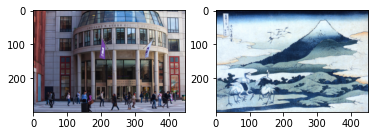

content_weight:100
epoch  1000   tensor(2.0833e+12, device='cuda:0', grad_fn=<AddBackward0>)


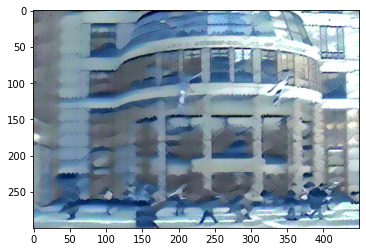

In [53]:
MODE = 'vgg'
content_index, style_index = 3, 5

content_path = f"neural style transfer/images/{content_index}.jpeg"
style_path = f"neural style transfer/style/{style_index}.jpeg"


if MODE == 'vgg':
  layers = {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '21': 'conv4_2',
      '28': 'conv5_1'
      }



  style_wt_meas = {"conv1_1" : 1.0, 
                  "conv2_1" : 0.8,
                  "conv3_1" : 0.4,
                  "conv4_1" : 0.2,
                  "conv5_1" : 0.1}
  model = models.vgg19(pretrained= True).features

elif MODE == 'alexnet':
  layers = {
    '0' : 'conv1',
    '3' : 'conv2',
    '6': 'conv3',
    '8': 'conv4',
    '10': 'conv5',
    }


  style_wt_meas = {"conv1" : 1.0, 
                  "conv2" : 0.8,
                  "conv3" : 0.4,
                  "conv4" : 0.2,
                  "conv5" : 0.1}
  model = models.alexnet(pretrained = True).features

else:
  raise KeyError('Model Type Not supported')

content_wt = 100
style_wt = 1e4


for p in model.parameters():
    p.requires_grad = False
model.to(device)
content_wts = [100]
style_wt = 10000
epoch = 1000
print_after = 1000
for i, content_wt in enumerate(content_wts):
  if i == 0:
    main(content_wt, epoch = epoch, print_after = print_after, plot = True)
  else:
    main(content_wt, epoch = epoch, print_after = print_after)